# Solution 1: Weighting Input Data

## Load Packages and Libraries

In [79]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


import data_prep_model_fit, drift
from sklearn.metrics import accuracy_score
from mleng_workshop_drift import addressing_solutions


## Preparing the model

In [81]:
red_wine_dataset = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv", sep=";")
white_wine_dataset = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv", sep=";")

In [82]:
wine_dataset = data_prep_model_fit.data_transform(red_wine_dataset, white_wine_dataset)
wine_dataset_train, wine_dataset_test = data_prep_model_fit.data_labels_change(wine_dataset)
X_train, y_train, X_test, y_test = data_prep_model_fit.data_split(wine_dataset_train, wine_dataset_test)
lgbm_model, params = data_prep_model_fit.lgbm_fit(X_train, y_train)

C:\Users\c.fraisse\PycharmProjects\pythonProject3\venv\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


We start with a 86% accuracy. Our model can be put in production.

In [83]:
accuracy_list = []

In [84]:
y_pred = lgbm_model.predict(X_test)
accuracy_list.append(accuracy_score(y_pred, y_test))
print(accuracy_score(y_pred, y_test))

0.865332820315506


## Corrupting the model : batch 1

We now corrupt our dataset with a real concept drift

In [85]:
data_generated = drift.dataset_generator_yield(data=wine_dataset_test, nb_sample=500)
dataset_sample = next(data_generated)
wine_dataset_corrupted_batch_1 = drift.drift_generator_concept_drift(data=dataset_sample,
                                                             column_name="alcohol",
                                                             value=11,
                                                             action="greater",
                                                             label_col="quality",
                                                             label_value=0)

In [86]:
X_test_corrupted_batch_1 = wine_dataset_corrupted_batch_1.loc[:, wine_dataset_corrupted_batch_1.columns != "quality"]
y_test_corrupted_batch_1 = wine_dataset_corrupted_batch_1["quality"]

Drift alarm, our accuracy score has decreased !!

In [87]:
y_pred = lgbm_model.predict(X_test_corrupted_batch_1)
accuracy_list.append(accuracy_score(y_pred, y_test_corrupted_batch_1))
print(accuracy_score(y_pred, y_test_corrupted_batch_1))

0.648


## Our solution: weighting input with time

We will weigh the importance of input data.
We will use a weighting that is inversely proportional to the age of the data such that more attention is paid to the most recent data (higher weight) and less attention is paid to the least recent data (smaller weight).

Retrain the model with the training and corrupted dataset

In [88]:
X_test_corrupted, y_test_corrupted = addressing_solutions.dataset_concat(wine_dataset_train, wine_dataset_corrupted_batch_1)

In [89]:
weighted_X_test, weighted_lgbm_model = addressing_solutions.weighted_dataset(X_test_corrupted, y_test_corrupted, params)

C:\Users\c.fraisse\PycharmProjects\pythonProject3\venv\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


#### Testing if accuracy has improved with a new corrupted batch

In [90]:
dataset_sample_batch_2 = next(data_generated)
wine_dataset_corrupted_batch_2 = drift.drift_generator_concept_drift(data=dataset_sample_batch_2,
                                                             column_name="alcohol",
                                                             value=11,
                                                             action="greater",
                                                             label_col="quality",
                                                             label_value=0)

In [91]:
X_test_corrupted_batch_2 = wine_dataset_corrupted_batch_2.loc[:, wine_dataset_corrupted_batch_2.columns != "quality"]
y_test_corrupted_batch_2 = wine_dataset_corrupted_batch_2["quality"]

It has increased again!

In [92]:
y_pred = weighted_lgbm_model.predict(X_test_corrupted_batch_2)
accuracy_list.append(accuracy_score(y_pred, y_test_corrupted_batch_2))
print(accuracy_score(y_pred, y_test_corrupted_batch_2))

0.716


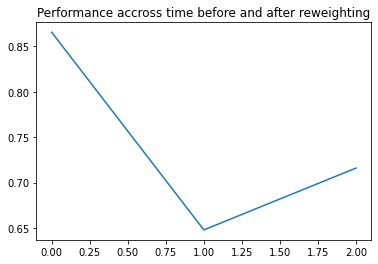

In [93]:
plt.plot(accuracy_list)
plt.title("Performance accross time before and after reweighting");

## How about retraining without reweighting?

In [94]:
X_test_corrupted, y_test_corrupted = addressing_solutions.dataset_concat(wine_dataset_train, wine_dataset_corrupted_batch_1)

In [95]:
no_reweight_lgbm_model, params = data_prep_model_fit.lgbm_fit(X_test_corrupted, y_test_corrupted)

C:\Users\c.fraisse\PycharmProjects\pythonProject3\venv\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


In [96]:
y_pred = no_reweight_lgbm_model.predict(X_test_corrupted_batch_2)
accuracy_score(y_pred, y_test_corrupted_batch_2)

0.716

In [97]:
def gradual_drift(data_train: pd.DataFrame,
                  data_to_compare: pd.DataFrame,
                  column_name: str,
                  value_drift: float,
                  params,
                  action: str = "increase",
                  nb_sample: int = 100,
                  nb_days: int = 5):
    """
    Generates a gradual drift
    Prints an alarm or a warning if a feature drift or anomaly has happened throughout a period of days
    """
    days = 0
    accuracy_list_weights = []
    accuracy_list_no_weights = []
    init_value_drift = value_drift
    data_generated = drift.dataset_generator_yield(data=data_to_compare, nb_sample=nb_sample)
    while days <= nb_days:
        #Fit
        print("Day", days, ":")
        dataset_corrupted_batch_1 = drift.drift_generator(data_generated=next(data_generated),
                                                  column_name=column_name,
                                                  value_of_drift=value_drift,
                                                  action=action)
        X_test_corrupted, y_test_corrupted = addressing_solutions.dataset_concat(data_train, dataset_corrupted_batch_1)
        weighted_X_test, weighted_lgbm_model = addressing_solutions.weighted_dataset(X_test_corrupted, y_test_corrupted, params)
        no_reweight_lgbm_model, params = data_prep_model_fit.lgbm_fit(X_test_corrupted, y_test_corrupted)
        #Predict
        dataset_corrupted_batch_2 = drift.drift_generator(data_generated=next(data_generated),
                                                  column_name=column_name,
                                                  value_of_drift=value_drift,
                                                  action=action)
        y_test_corrupted_batch_2 = dataset_corrupted_batch_2["quality"]
        X_test_corrupted_batch_2 = wine_dataset_corrupted_batch_2.loc[:, wine_dataset_corrupted_batch_2.columns != "quality"]
        y_pred_no_weigth = no_reweight_lgbm_model.predict(X_test_corrupted_batch_2)
        accuracy_list_no_weights.append(accuracy_score(y_pred_no_weigth, y_test_corrupted_batch_2))
        y_pred_weigth = weighted_lgbm_model.predict(X_test_corrupted_batch_2)
        accuracy_list_weights.append(accuracy_score(y_pred_weigth, y_test_corrupted_batch_2))
        data_train = pd.concat([data_train, dataset_corrupted_batch_1, dataset_corrupted_batch_2], axis=0)
        days += 1
        value_drift += init_value_drift
    return accuracy_list_weights, accuracy_list_no_weights

In [98]:
accuracy_list_weights, accuracy_list_no_weights = gradual_drift(wine_dataset_train,
                                                                wine_dataset_test,
                                                                "alcohol",
                                                                5,
                                                                params,
                                                                "increase",
                                                                500,
                                                                5)

Day 0 :


C:\Users\c.fraisse\PycharmProjects\pythonProject3\venv\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
C:\Users\c.fraisse\PycharmProjects\pythonProject3\venv\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


Day 1 :


C:\Users\c.fraisse\PycharmProjects\pythonProject3\venv\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
C:\Users\c.fraisse\PycharmProjects\pythonProject3\venv\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


Day 2 :


C:\Users\c.fraisse\PycharmProjects\pythonProject3\venv\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
C:\Users\c.fraisse\PycharmProjects\pythonProject3\venv\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


Day 3 :


C:\Users\c.fraisse\PycharmProjects\pythonProject3\venv\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
C:\Users\c.fraisse\PycharmProjects\pythonProject3\venv\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


Day 4 :


C:\Users\c.fraisse\PycharmProjects\pythonProject3\venv\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
C:\Users\c.fraisse\PycharmProjects\pythonProject3\venv\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


Day 5 :


C:\Users\c.fraisse\PycharmProjects\pythonProject3\venv\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
C:\Users\c.fraisse\PycharmProjects\pythonProject3\venv\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


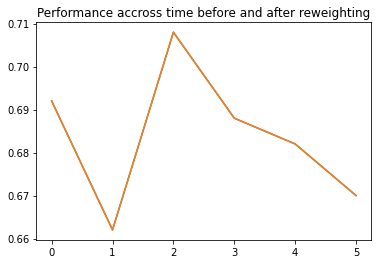

In [100]:
plt.plot(accuracy_list_no_weights)
plt.plot(accuracy_list_weights)
plt.title("Performance accross time before and after reweighting");

## To try with another model maybe?